In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import random
from PIL import Image,ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle


In [2]:
#Dataset
import zipfile
z=zipfile.ZipFile('archive (1).zip')
z.extractall()

In [3]:
#Directories for training and testing data
train_dir='Training'
test_dir='Testing'
#load and shuffle the train data
train_paths=[]
train_labels=[]
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths,train_labels=shuffle(train_paths,train_labels)
#Load and shuffle the test data
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)
test_paths,test_labels=shuffle(test_paths,test_labels)

### Data visualization

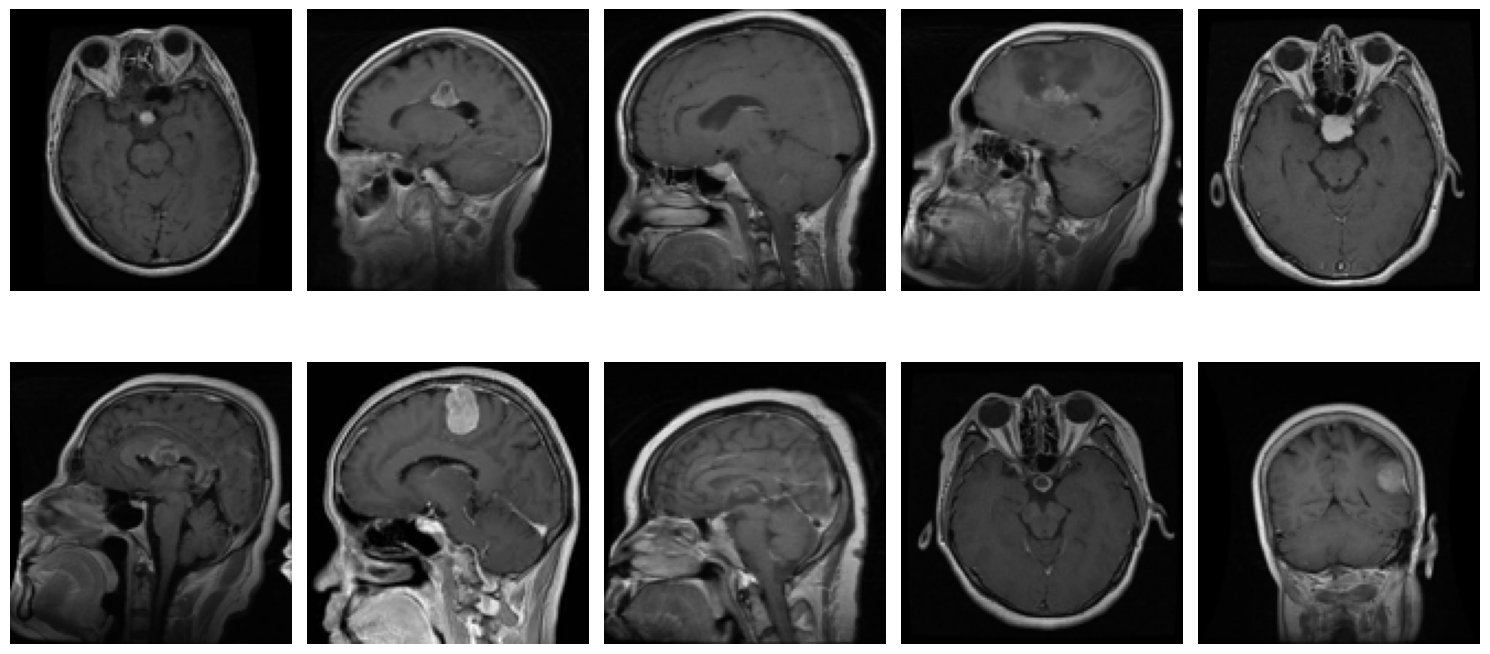

In [4]:
#Select random indices for 10 images
random_indices=random.sample(range(len(train_paths)),10)
random_indices
#Create a figure to display images in 2 rows
fig,axes=plt.subplots(2,5,figsize=(15,8))
axes=axes.ravel()
#Loop through the random indices and display images
for i,index in enumerate(random_indices):
    img_path=train_paths[index]
    img=Image.open(img_path)
    img=img.resize((128,128))

    #Display images
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [5]:
IMG_SIZE = 224

#Load & preprocess a single image
def process_image(path):
    img = cv2.imread(path)                      # read
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
    img = img / 255.0                           # normalize
    return img

# Load FULL Training Dataset
X_train = []
for path in train_paths:
    X_train.append(process_image(path))

X_train = np.array(X_train)
print("X_train shape:", X_train.shape)

#  Load FULL Testing Dataset
X_test = []
for path in test_paths:
    X_test.append(process_image(path))

X_test = np.array(X_test)
print("X_test shape:", X_test.shape)

X_train shape: (2870, 224, 224, 3)
X_test shape: (394, 224, 224, 3)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels into integers
le = LabelEncoder()
y_train_int = le.fit_transform(train_labels)
y_test_int = le.transform(test_labels)

print("Label mapping:", le.classes_)

# Convert integers into one-hot vectors
y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Label mapping: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']
y_train shape: (2870, 4)
y_test shape: (394, 4)


## Data Augmentation+CNN Architecture

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D,
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation
)
from tensorflow.keras import Input

IMG_SIZE = 224
num_classes = y_train.shape[1]

# -----------------------------------------------
# 1️⃣ BUILD THE CNN MODEL WITH INPUT LAYER
# -----------------------------------------------
model = Sequential()

# INPUT LAYER → THIS FIXES THE BUILD ERROR
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# -----------------------------------------------
# 2️⃣ DATA AUGMENTATION (NO RandomContrast)
# -----------------------------------------------
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.15))
model.add(RandomZoom(0.1))
model.add(RandomTranslation(0.1, 0.1))

# -----------------------------------------------
# 3️⃣ CONVOLUTION BLOCKS
# -----------------------------------------------
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# -----------------------------------------------
# 4️⃣ GLOBAL POOLING + DENSE
# -----------------------------------------------
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

# -----------------------------------------------
# 5️⃣ MODEL SUMMARY
# -----------------------------------------------
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     1

In [8]:
#Compilation

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
#model training
history = model.fit(
    X_train,
    y_train,
    epochs=7,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/7
81/81 [==============================] - 229s 3s/step - loss: 1.0835 - accuracy: 0.5401 - val_loss: 1.3490 - val_accuracy: 0.2857
Epoch 2/7
81/81 [==============================] - 217s 3s/step - loss: 0.9239 - accuracy: 0.6136 - val_loss: 1.3601 - val_accuracy: 0.3798
Epoch 3/7
81/81 [==============================] - 213s 3s/step - loss: 0.8531 - accuracy: 0.6477 - val_loss: 1.4545 - val_accuracy: 0.2857
Epoch 4/7
81/81 [==============================] - 214s 3s/step - loss: 0.7784 - accuracy: 0.6841 - val_loss: 1.6784 - val_accuracy: 0.2997
Epoch 5/7
81/81 [==============================] - 214s 3s/step - loss: 0.7529 - accuracy: 0.6845 - val_loss: 1.2563 - val_accuracy: 0.3833
Epoch 6/7
81/81 [==============================] - 214s 3s/step - loss: 0.6904 - accuracy: 0.7189 - val_loss: 1.3130 - val_accuracy: 0.4077
Epoch 7/7
81/81 [==============================] - 243s 3s/step - loss: 0.6418 - accuracy: 0.7437 - val_loss: 1.2949 - val_accuracy: 0.4460


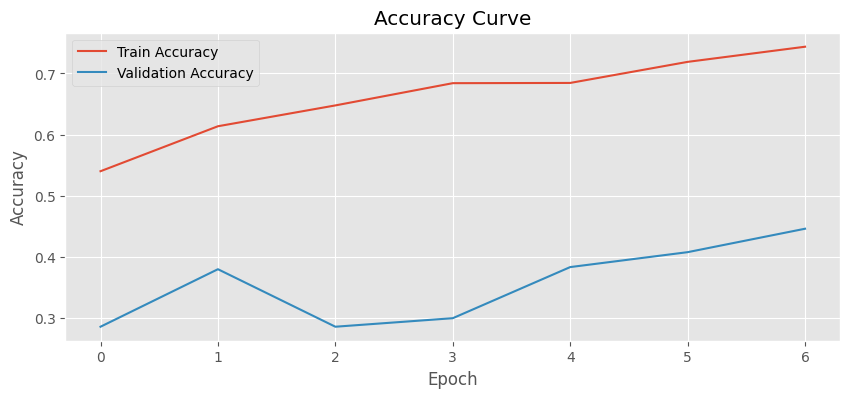

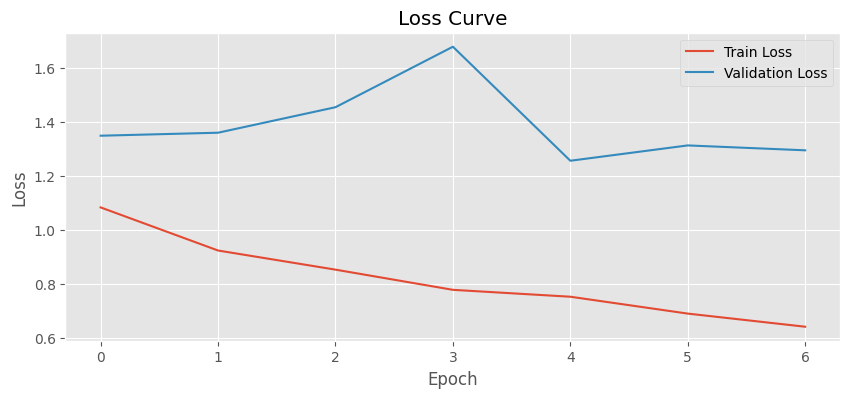

In [17]:
# Accuracy Plot
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities → class indices
y_pred = y_pred_prob.argmax(axis=1)

# Convert actual one-hot test labels → class indices
y_true = y_test.argmax(axis=1)


13/13 [==============================] - 7s 498ms/step


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)


Test Accuracy: 0.4010152284263959
Test Precision: 0.36051950959775053
Test Recall: 0.44079654188349837
Test F1 Score: 0.33665584381832864


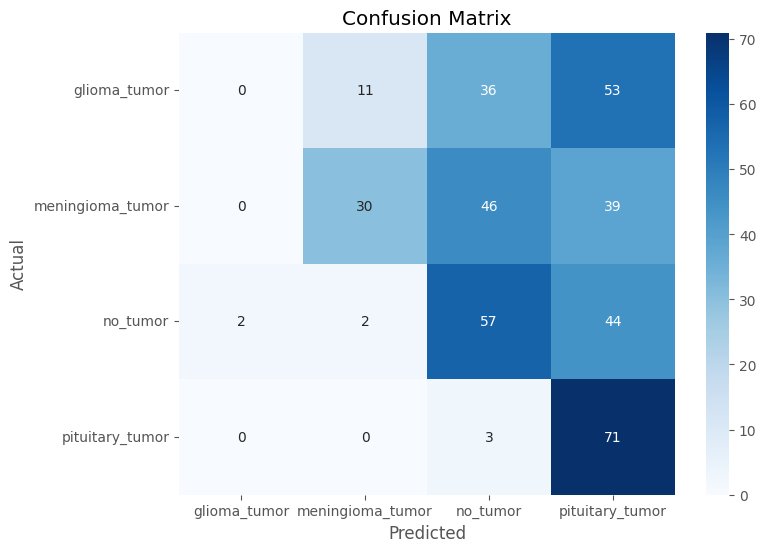

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = le.classes_   

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
model.save("brain_tumor_cnn_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    class_index = np.argmax(pred)
    class_name = le.classes_[class_index]
    confidence = pred[0][class_index]

    print("Predicted Class:", class_name)
    print("Confidence:", confidence)


# EXAMPLE:
#predict_single_image("Testing/glioma_tumor/Tr-gl_0017.jpg")



In [29]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def gradcam_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # find last conv layer name
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer_name = layer.name
            break

    heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * 0.4 + (img_array * 255)
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img_array)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

# Example:
# gradcam_image("Testing/glioma_tumor/Tr-gl_0017.jpg")


In [30]:
np.save("class_labels.npy", le.classes_)